In [ ]:
import cv2
import time

cam = cv2.VideoCapture(0)

cv2.namedWindow("test")

img_counter = 0

while True:

    ret, frame = cam.read()
    if not ret:
        print("failed to grab frame")
        break
  
    img_name = "opencv_frame_{}.png".format(img_counter)
    cv2.imwrite(img_name, frame)
    print("{} written!".format(img_name))
    img_counter += 1
    time.sleep(1)

cam.release()

[INFO] loading model and label binarizer...
[INFO] running selective search...
[INFO] proposal shape: (1842, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


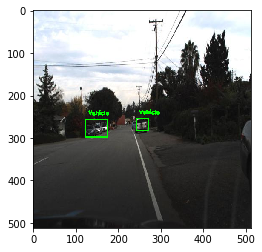

[INFO] running selective search...
[INFO] proposal shape: (1888, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


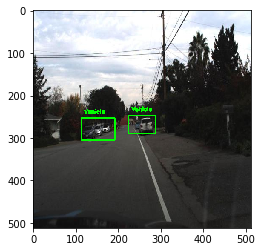

[INFO] running selective search...
[INFO] proposal shape: (1927, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


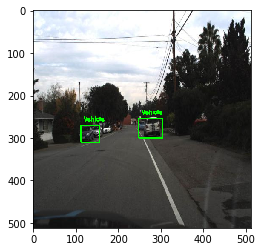

[INFO] running selective search...
[INFO] proposal shape: (1964, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


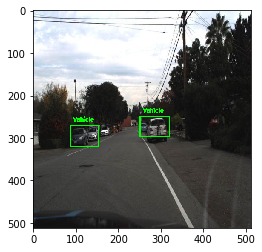

[INFO] running selective search...
[INFO] proposal shape: (1814, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


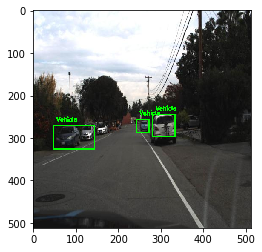

[INFO] running selective search...
[INFO] proposal shape: (1924, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


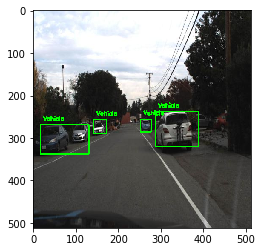

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


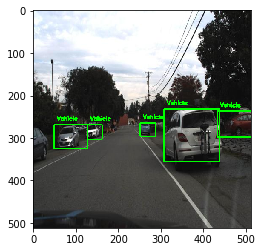

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


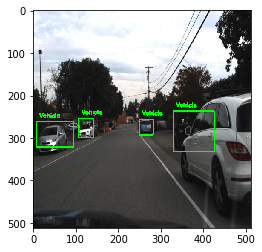

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


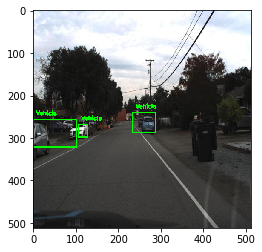

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


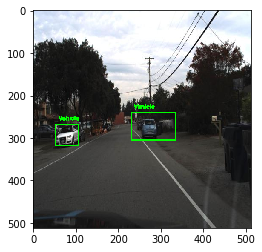

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


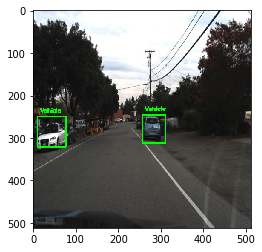

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


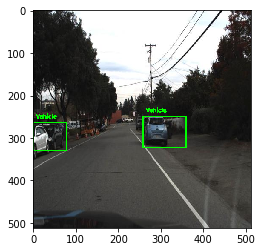

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


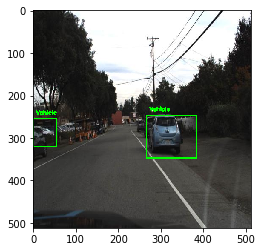

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


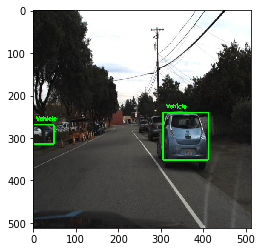

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


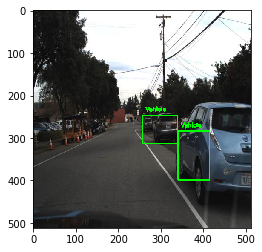

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


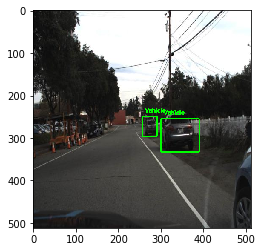

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


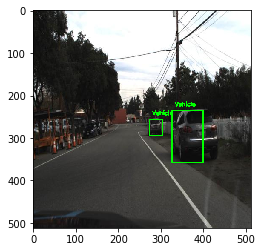

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


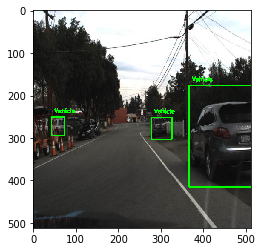

[INFO] running selective search...
[INFO] proposal shape: (1917, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


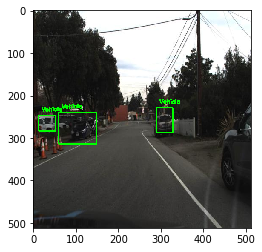

[INFO] running selective search...
[INFO] proposal shape: (1810, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


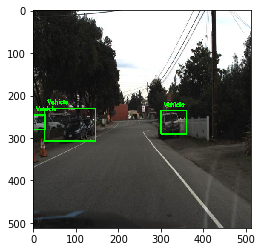

[INFO] running selective search...
[INFO] proposal shape: (1940, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


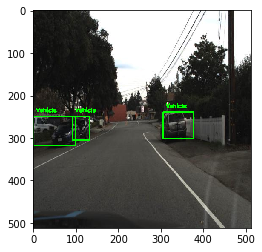

[INFO] running selective search...
[INFO] proposal shape: (1875, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


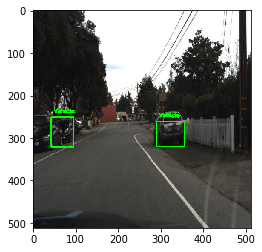

[INFO] running selective search...
[INFO] proposal shape: (2000, 200, 200, 3)
[INFO] classifying proposals...
[INFO] applying NMS...


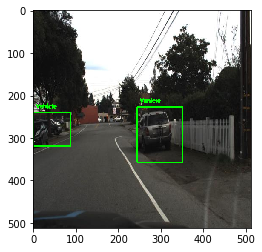

In [3]:
# import the necessary packages
import os
import cv2
import pickle
import imutils
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as mplot
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# load the our fine-tuned model and label binarizer from disk
print("[INFO] loading model and label binarizer...")

model = load_model('vehicle_detector.h5')
lb    = pickle.loads(open('label_encoder.pickle', "rb").read())

files=os.listdir('images')
files.sort()

for filename in files:
  # load the input image from disk
  image = cv2.imread('images/'+filename)

  # run selective search on the image to generate bounding box proposal regions
  print("[INFO] running selective search...")
  ss    = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(image)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()

  # initialize the list of region proposals that we'll be classifying along with their associated bounding boxes
  proposals = []
  boxes     = []

  # loop over the region proposal bounding box coordinates generated by running selective search
  for (x, y, w, h) in rects[:2000]:
	
	  # extract the region from the input image, convert it from BGR to RGB channel ordering, and then resize it to the required input dimensions of our trained CNN
    roi = image[y:y + h, x:x + w]
    roi = cv2.resize(roi, (200,200),interpolation=cv2.INTER_CUBIC)
	
	  # further preprocess the ROI
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roi = img_to_array(roi)
    roi = preprocess_input(roi)
	
	  # update our proposals and bounding boxes lists
    proposals.append(roi)
    boxes.append((x, y, x + w, y + h))

  # convert the proposals and bounding boxes into NumPy arrays
  proposals = np.array(proposals, dtype="float32")
  boxes     = np.array(boxes, dtype="int32")
  print("[INFO] proposal shape: {}".format(proposals.shape))

  # classify each of the proposal ROIs using fine-tuned model
  print("[INFO] classifying proposals...")
  proba     = model.predict(proposals)

  # find the index of all predictions that are positive for the "vehicle" class
  print("[INFO] applying NMS...")
  labels    = lb.classes_[np.argmax(proba, axis=1)]
  idxs      = np.where(labels == "vehicle")[0]

  # use the indexes to extract all bounding boxes and associated class label probabilities associated with the "vehicle" class
  boxes = boxes[idxs]
  proba = proba[idxs][:, 1]

  # further filter indexes by enforcing a minimum prediction probability be met
  idxs  = np.where(proba >= 0.90)
  boxes = boxes[idxs]
  proba = proba[idxs]

  # run non-maxima suppression on the bounding boxes
  boxIdxs = tf.image.non_max_suppression(boxes,proba,10,iou_threshold=0.05)

  # loop over the bounding box indexes
  for i in boxIdxs:
	
	  (startX, startY, endX, endY) = boxes[i]
	  if (endY-startY)<=(endX-startX)*2:
		  # draw the bounding box, label, and probability on the image
		  cv2.rectangle(image, (startX, startY), (endX, endY),(0, 255, 0), 2)
		  y   = startY - 10 if startY - 10 > 10 else startY + 10
		  text= " Vehicle"
		  cv2.putText(image, text, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

  # show the output image *after* running NMS
  image=cv2.resize(image,(512,512),interpolation=cv2.INTER_CUBIC)
  cv2.imwrite('result/'+filename,image)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  mplot.imshow(image)
  mplot.show()

In [ ]:
TEST_VIDEO = "result"
  
# Video Generating function 
def generate_video(): 
    image_folder = 'result' # make sure to use your folder 
    video_name = 'mygeneratedvideo.avi'
      
    images = [img for img in list(paths.list_images(TEST_VIDEO)) 
              if img.endswith(".jpg") or
                 img.endswith(".jpeg") or
                 img.endswith("png")] 
     
    # Array images should only consider 
    # the image files ignoring others if any 
    print(images)  
  
    frame = cv2.imread(os.path.join(image_folder, images[0])) 
  
    # setting the frame width, height width 
    # the width, height of first image 
    height, width, layers = frame.shape   
  
    video = cv2.VideoWriter(video_name, 0, 1, (width, height))  
  
    # Appending the images to the video one by one 
    for image in images:  
        video.write(cv2.imread(os.path.join(image_folder, image)))  
      
    # Deallocating memories taken for window creation 
    cv2.destroyAllWindows()  
    video.release()  # releasing the video generated 
  
  
# Calling the generate_video function 
generate_video()